In [1]:
import os
os.chdir(os.environ.get('PROJECT_PATH'))
import pandas as pd
import matplotlib.pyplot as plt
from traindelays.ml_logic import preprocess as p
from traindelays import utils as u
from traindelays.params import *
%load_ext autoreload
%autoreload 2

**Table of contents**<a id='toc0_'></a>    
- [Features Construction](#toc1_)    
  - [Loading the Data](#toc1_1_)    
  - [Temporal Features](#toc1_2_)    
    - [ENGLISH DAY TYPE](#toc1_2_1_)    
    - [PLANNED_ORIG_GBTT_DATETIME_AFF and PLANNED_DEST_GBTT_DATETIME_AFF](#toc1_2_2_)    
  - [Geographical Features](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Features Construction](#toc0_)

## <a id='toc1_1_'></a>[Loading the Data](#toc0_)

In [2]:
df = u.read_data_from_bq(credentials=SERVICE_ACCOUNT,gcp_project=GCP_PROJECT,bq_dataset=BQ_DATASET,table=RAIL_DATA_TABLE_ID)
df.head()


,FINANCIAL_YEAR_AND_PERIOD,ORIGIN_DEPARTURE_DATE,TRUST_TRAIN_ID_AFFECTED,PLANNED_ORIG_LOC_CODE_AFF,PLANNED_ORIG_WTT_DATETIME_AFF,PLANNED_ORIG_GBTT_DATETIME_AFF,PLANNED_DEST_LOC_CODE_AFFECTED,PLANNED_DEST_WTT_DATETIME_AFF,PLANNED_DEST_GBTT_DATETIME_AFF,TRAIN_SERVICE_CODE_AFFECTED,...,INCIDENT_EQUIPMENT,INCIDENT_DESCRIPTION,REACTIONARY_REASON_CODE,INCIDENT_RESPONSIBLE_TRAIN,RESP_TRAIN,REACT_TRAIN,START_STANOX,END_STANOX,EVENT_DATETIME,PFPI_MINUTES
0,2021/22_P04,03-Jul-21,722C28MK03,72000,2021-03-07 12:15:00+00:00,2021-03-07 12:15:00+00:00,72410,2021-03-07 13:05:00+00:00,2021-03-07 13:05:00+00:00,22216000,...,221108,9M50 3 LATE START EDB,YD,None,None,361A27MH03,72311,72410,2021-03-07 13:09:00+00:00,4.0
1,2019/20_P12,05-Feb-20,522Y30MZ05,52226,2020-05-02 20:05:00+00:00,2020-05-02 20:05:00+00:00,87219,2020-05-02 21:07:00+00:00,2020-05-02 21:07:00+00:00,22214000,...,334014,2C28 UNIT FLT WES,YD,2C28,062C28MI05,522N36MY05,72419,72275,2020-05-02 20:48:00+00:00,3.0
2,2019/20_P12,05-Feb-20,872N45M705,87132,2020-05-02 21:07:00+00:00,2020-05-02 21:07:00+00:00,52226,2020-05-02 22:07:00+00:00,2020-05-02 22:09:00+00:00,22214000,...,334014,2C28 UNIT FLT WES,YA,2C28,062C28MI05,522N38MZ05,87132,87132,2020-05-02 21:14:00+00:00,4.0
3,2019/20_P12,05-Feb-20,522Y28MY05,52226,2020-05-02 19:53:00+00:00,2020-05-02 19:53:00+00:00,87219,2020-05-02 20:54:00+00:00,2020-05-02 20:55:00+00:00,22214000,...,334014,2C28 UNIT FLT WES,YI,2C28,062C28MI05,872N23MX05,52226,52226,2020-05-02 19:55:00+00:00,2.0
4,2019/20_P12,05-Feb-20,522Y48M805,52226,2020-05-02 22:14:00+00:00,2020-05-02 22:14:00+00:00,87219,2020-05-02 23:21:00+00:00,2020-05-02 23:21:00+00:00,22214000,...,334014,2C28 UNIT FLT WES,YI,2C28,062C28MI05,872N45M705,52226,52226,2020-05-02 22:23:00+00:00,9.0


Data is splitted according to their index, in order to have a stable train/test split.

In [3]:
train, test = u.split_train_test_by_id(data = df, test_ratio = 0.33, id_column = 'index')
X_train =train.drop(columns=['PFPI_MINUTES'])
X_test = test.drop(columns=['PFPI_MINUTES'])
y_train = train['PFPI_MINUTES']
y_test = test['PFPI_MINUTES']

The features dataset is then cleaned of redundant columns.

In [4]:
X_train = p.drop_columns(X_train)
print(X_train.dtypes)

Dropped columns: START_STANOX, END_STANOX, PLANNED_ORIG_WTT_DATETIME_AFF, PLANNED_DEST_WTT_DATETIME_AFF, FINANCIAL_YEAR_AND_PERIOD, ORIGIN_DEPARTURE_DATE, INCIDENT_CREATE_DATE, INCIDENT_START_DATETIME, INCIDENT_END_DATETIME, TRAILING_LOAD_AFFECTED, TIMING_LOAD_AFFECTED, REACT_TRAIN, INCIDENT_RESPONSIBLE_TRAIN, RESP_TRAIN, INCIDENT_EQUIPMENT, INCIDENT_NUMBER, TRUST_TRAIN_ID_AFFECTED, INCIDENT_RESPONSIBLE_TRAIN, RESP_TRAIN, INCIDENT_EQUIPMENT, INCIDENT_NUMBER, INCIDENT_DESCRIPTION, EVENT_DATETIME
PLANNED_ORIG_LOC_CODE_AFF                       Int64
PLANNED_ORIG_GBTT_DATETIME_AFF    datetime64[us, UTC]
PLANNED_DEST_LOC_CODE_AFFECTED                  Int64
PLANNED_DEST_GBTT_DATETIME_AFF    datetime64[us, UTC]
TRAIN_SERVICE_CODE_AFFECTED                    object
SERVICE_GROUP_CODE_AFFECTED                    object
ENGLISH_DAY_TYPE                               object
APP_TIMETABLE_FLAG_AFF                         object
TRAIN_SCHEDULE_TYPE_AFFECTED                   object
TRACTION_TYPE_

## <a id='toc1_2_'></a>[Temporal Features](#toc0_)

We have the following temporal information:

:pushpin: **ENGLISH_DAY_TYPE** : It indicates if it's a weekday (WD), Saturday (SU), Sunday (SA) or bank holiday (BH). 

:pushpin: **PLANNED_ORIG_GBTT_DATETIME_AFF** and **PLANNED_DEST_GBTT_DATETIME_AFF**: The planned arrival and departure times according to the published timetable. 

:triangular_flag_on_post: Dates need to be offset for Daylight Saving Time.


### <a id='toc1_2_1_'></a>[ENGLISH DAY TYPE](#toc0_)

**ENGLISH_DAY_TYPE** does not have any missing values. However, in 2020, an additionaly category (BD) was logged (to keep track of Boxing Day). Since it is has been used only for this year, its instance will be substituted with "BH".

In [5]:
display(X_train['ENGLISH_DAY_TYPE'].isna().sum())

0

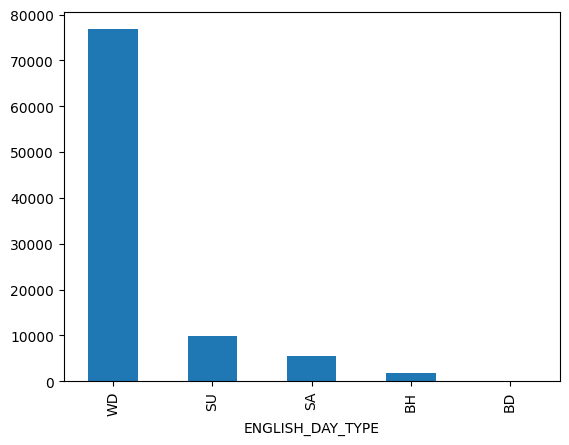

In [6]:
X_train['ENGLISH_DAY_TYPE'].value_counts().plot(kind='bar')
plt.show()

In [7]:
print("Before subsituting for Boxing Day category")
display(X_train['ENGLISH_DAY_TYPE'].value_counts(dropna=False))
X_train = p.boxing_day_holiday_normalization(X_train)
print("After subsituting for Boxing Day category")
display(X_train['ENGLISH_DAY_TYPE'].value_counts(dropna=False))

Before subsituting for Boxing Day category


ENGLISH_DAY_TYPE
WD    76826
SU     9787
SA     5503
BH     1810
BD        4
Name: count, dtype: int64

After subsituting for Boxing Day category


ENGLISH_DAY_TYPE
WD    76826
SU     9787
SA     5503
BH     1814
Name: count, dtype: int64

### <a id='toc1_2_2_'></a>[PLANNED_ORIG_GBTT_DATETIME_AFF and PLANNED_DEST_GBTT_DATETIME_AFF](#toc0_)

**PLANNED_ORIG_GBTT_DATETIME_AFF** and **PLANNED_DEST_GBTT_DATETIME_AFF** do, but since trains not comparing into the GBTT timetables are freight trains. Therefore, we can drop these rows. 

In [8]:
dates_cols = ['PLANNED_ORIG_GBTT_DATETIME_AFF','PLANNED_DEST_GBTT_DATETIME_AFF']
X_train[dates_cols].isna().sum()/len(X_train)
X_train.dropna(subset = ['PLANNED_ORIG_GBTT_DATETIME_AFF','PLANNED_DEST_GBTT_DATETIME_AFF'], inplace = True)

To make all the dates comparables, we have to offset the daylight saving time.

In [9]:
X_train[dates_cols] = X_train[dates_cols].apply(p.apply_dst_offset,axis=1)

Features that can be obtained by **PLANNED_ORIG_GBTT_DATETIME_AFF** and **PLANNED_DEST_GBTT_DATETIME_AFF** are Day, Week and Month of the departure date.

In [10]:
X_train['PLANNED_ORIG_GBTT_MONTH'] = X_train['PLANNED_ORIG_GBTT_DATETIME_AFF'].dt.month
X_train['PLANNED_ORIG_GBTT_WEEK'] = X_train['PLANNED_ORIG_GBTT_DATETIME_AFF'].dt.strftime("%V").astype('int32')
X_train['PLANNED_ORIG_GBTT_DAY']  = X_train['PLANNED_ORIG_GBTT_DATETIME_AFF'].dt.day


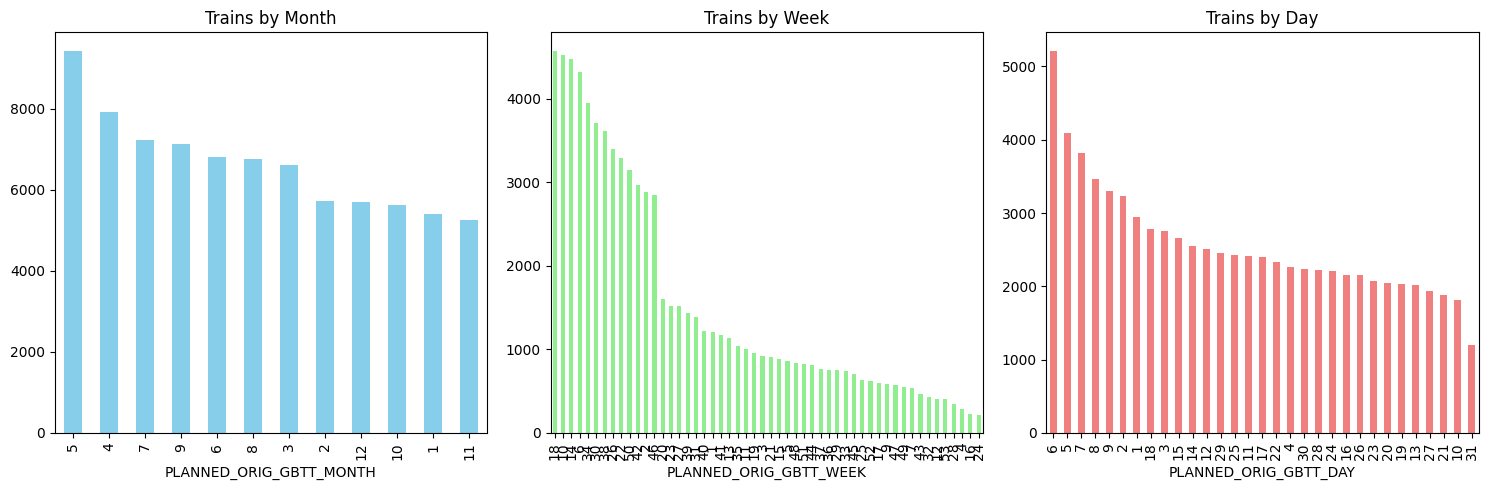

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

X_train['PLANNED_ORIG_GBTT_MONTH'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Trains by Month')

X_train['PLANNED_ORIG_GBTT_WEEK'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Trains by Week')

X_train['PLANNED_ORIG_GBTT_DAY'].value_counts().plot(kind='bar', ax=axes[2], color='lightcoral')
axes[2].set_title('Trains by Day')

plt.tight_layout()
plt.show()

In [12]:
X_train = u.add_cyclical_features(X_train, 'PLANNED_ORIG_GBTT_MONTH', 12)
X_train = u.add_cyclical_features(X_train, 'PLANNED_ORIG_GBTT_WEEK', 53)
X_train = u.add_cyclical_features(X_train, 'PLANNED_ORIG_GBTT_DAY', 31)
display(X_train)

,PLANNED_ORIG_LOC_CODE_AFF,PLANNED_ORIG_GBTT_DATETIME_AFF,PLANNED_DEST_LOC_CODE_AFFECTED,PLANNED_DEST_GBTT_DATETIME_AFF,TRAIN_SERVICE_CODE_AFFECTED,SERVICE_GROUP_CODE_AFFECTED,ENGLISH_DAY_TYPE,APP_TIMETABLE_FLAG_AFF,TRAIN_SCHEDULE_TYPE_AFFECTED,TRACTION_TYPE_AFFECTED,...,REACTIONARY_REASON_CODE,PLANNED_ORIG_GBTT_MONTH,PLANNED_ORIG_GBTT_WEEK,PLANNED_ORIG_GBTT_DAY,PLANNED_ORIG_GBTT_MONTH_sin,PLANNED_ORIG_GBTT_MONTH_cos,PLANNED_ORIG_GBTT_WEEK_sin,PLANNED_ORIG_GBTT_WEEK_cos,PLANNED_ORIG_GBTT_DAY_sin,PLANNED_ORIG_GBTT_DAY_cos
80896,52226,2020-07-15 10:46:00+00:00,87132,2020-07-15 11:48:00+00:00,22214000,EK01,WD,Y,LTP,EMU,...,None,7,29,15,-5.000000e-01,-8.660254e-01,-0.292057,-0.956401,0.101168,-0.994869
107575,72419,2019-06-02 14:10:00+00:00,51531,2019-06-02 14:44:00+00:00,21921000,EK01,SU,Y,LTP,EMU,...,,6,22,2,1.224647e-16,-1.000000e+00,0.508531,-0.861044,0.394356,0.918958
40398,51815,2020-08-14 18:01:00+00:00,52741,2020-08-14 18:45:00+00:00,21234001,EK04,WD,Y,(V)STP Overlay,EMU,...,YB,8,33,14,-8.660254e-01,-5.000000e-01,-0.696551,-0.717507,0.299363,-0.954139
21423,52226,2020-06-01 19:59:00+00:00,87132,2020-06-01 21:01:00+00:00,22214000,EK01,WD,Y,LTP,EMU,...,YD,6,23,1,1.224647e-16,-1.000000e+00,0.403123,-0.915146,0.201299,0.979530
114227,87625,2022-10-18 19:02:00+00:00,52051,2022-10-18 19:48:00+00:00,22218000,EK99,WD,Y,LTP,EMU,...,YB,10,42,18,-8.660254e-01,5.000000e-01,-0.964636,0.263587,-0.485302,-0.874347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126324,87651,2018-07-23 07:15:00+00:00,52051,2018-07-23 08:09:00+00:00,22215003,EK03,WD,Y,LTP,EMU,...,,7,30,23,-5.000000e-01,-8.660254e-01,-0.403123,-0.915146,-0.998717,-0.050649
137337,52226,2022-04-07 16:36:00+00:00,87219,2022-04-07 17:38:00+00:00,22214000,EK01,WD,Y,LTP,EMU,...,YD,4,14,7,8.660254e-01,-5.000000e-01,0.996050,-0.088796,0.988468,0.151428
54886,87651,2020-02-05 08:07:00+00:00,52051,2020-02-05 09:04:00+00:00,22215003,EK03,SA,Y,(V)STP Base,EMU,...,None,2,6,5,8.660254e-01,5.000000e-01,0.652822,0.757511,0.848644,0.528964
110268,51946,2022-06-05 15:23:00+00:00,52741,2022-06-05 15:56:00+00:00,21234001,EK04,SU,Y,LTP,EMU,...,,6,22,5,1.224647e-16,-1.000000e+00,0.508531,-0.861044,0.848644,0.528964


In [13]:
X_train.drop(columns=['PLANNED_ORIG_GBTT_DATETIME_AFF','PLANNED_DEST_GBTT_DATETIME_AFF',
                      'PLANNED_ORIG_GBTT_MONTH', 'PLANNED_ORIG_GBTT_WEEK','PLANNED_ORIG_GBTT_DAY'],inplace=True)
display(X_train.columns)

Index(['PLANNED_ORIG_LOC_CODE_AFF', 'PLANNED_DEST_LOC_CODE_AFFECTED',
       'TRAIN_SERVICE_CODE_AFFECTED', 'SERVICE_GROUP_CODE_AFFECTED',
       'ENGLISH_DAY_TYPE', 'APP_TIMETABLE_FLAG_AFF',
       'TRAIN_SCHEDULE_TYPE_AFFECTED', 'TRACTION_TYPE_AFFECTED',
       'UNIT_CLASS_AFFECTED', 'SECTION_CODE', 'NETWORK_RAIL_LOCATION_MANAGER',
       'RESPONSIBLE_MANAGER', 'INCIDENT_REASON', 'REACTIONARY_REASON_CODE',
       'PLANNED_ORIG_GBTT_MONTH_sin', 'PLANNED_ORIG_GBTT_MONTH_cos',
       'PLANNED_ORIG_GBTT_WEEK_sin', 'PLANNED_ORIG_GBTT_WEEK_cos',
       'PLANNED_ORIG_GBTT_DAY_sin', 'PLANNED_ORIG_GBTT_DAY_cos'],
      dtype='object')

## <a id='toc1_3_'></a>[Geographical Features](#toc0_)

The departure and arrival stations are expresses as STANOX codes (stations identifier codes). The number of unique STANOX codes is too high to consider one-hot encoding, so we are going to retrieve the latitude/longitude of each station.

In [14]:
stanox_cols = ['PLANNED_ORIG_LOC_CODE_AFF','PLANNED_DEST_LOC_CODE_AFFECTED']
u.print_summary_stats(df = X_train, cols_list=stanox_cols)

Missing Values:
PLANNED_ORIG_LOC_CODE_AFF         0.0
PLANNED_DEST_LOC_CODE_AFFECTED    0.0
dtype: float64

Unique Values:
PLANNED_ORIG_LOC_CODE_AFF         44
PLANNED_DEST_LOC_CODE_AFFECTED    40
dtype: int64

Value Counts:

PLANNED_ORIG_LOC_CODE_AFF
52226    12371
87219    10788
87651     6392
87132     6110
52051     5710
72419     5233
72410     4722
52741     4563
52074     4526
72000     2851
52731     2818
87625     2633
51531     2563
88392     2266
51815     2148
51946     2081
72275      764
51533      221
87603      141
87203      114
72277      110
72421       87
72253       65
52088       48
72313       47
72242       34
52040       33
50392       30
63641       25
87572       23
51541       18
50401       17
72017       13
51558       11
51951        5
87626        5
72241        4
72311        2
72271        2
72413        2
52053        1
87574        1
51949        1
51529        1
<NA>         0
Name: count, dtype: Int64

PLANNED_DEST_LOC_CODE_AFFECTED
52226    13341


In [15]:
lon_lat_df = u.read_data_from_bq(credentials = SERVICE_ACCOUNT,
                  gcp_project = GCP_PROJECT, bq_dataset = BQ_DATASET,
                  table = GEO_COOORDINATES_TABLE_ID)

In [16]:
lon_lat_df.head()

,Station_Name,Stanox,Latitude,Longitude
0,Edmonton Green Rail Station,51949,51.624929,-0.061087
1,Clapham Junction,87219,51.463350,-0.172530
2,Shenfield Rail Station,50328,51.630878,0.329879
3,Walthamstow Queens Road Rail Station,51553,51.581503,-0.023819
4,South Tottenham,51558,51.580430,-0.071820


In [17]:
lon_lat_df = lon_lat_df[['Stanox','Latitude','Longitude']]
X_train = pd.merge(X_train, lon_lat_df, left_on='PLANNED_ORIG_LOC_CODE_AFF',right_on='Stanox', how='left')
X_train.rename(columns={'Latitude':'ORIG_LAT','Longitude':'ORIG_LON'},inplace=True)
X_train = pd.merge(X_train, lon_lat_df, left_on='PLANNED_DEST_LOC_CODE_AFFECTED',right_on='Stanox', how='left')
X_train.rename(columns={'Latitude':'DEST_LAT','Longitude':'DEST_LON'},inplace=True)
X_train.drop(columns=['PLANNED_ORIG_LOC_CODE_AFF', 'PLANNED_DEST_LOC_CODE_AFFECTED','Stanox_x','Stanox_y'],inplace=True)

In [18]:
X_train.head()

,TRAIN_SERVICE_CODE_AFFECTED,SERVICE_GROUP_CODE_AFFECTED,ENGLISH_DAY_TYPE,APP_TIMETABLE_FLAG_AFF,TRAIN_SCHEDULE_TYPE_AFFECTED,TRACTION_TYPE_AFFECTED,UNIT_CLASS_AFFECTED,SECTION_CODE,NETWORK_RAIL_LOCATION_MANAGER,RESPONSIBLE_MANAGER,...,PLANNED_ORIG_GBTT_MONTH_sin,PLANNED_ORIG_GBTT_MONTH_cos,PLANNED_ORIG_GBTT_WEEK_sin,PLANNED_ORIG_GBTT_WEEK_cos,PLANNED_ORIG_GBTT_DAY_sin,PLANNED_ORIG_GBTT_DAY_cos,ORIG_LAT,ORIG_LON,DEST_LAT,DEST_LON
0,22214000,EK01,WD,Y,LTP,EMU,378.0,52226:52045,OQHQ,VEK1,...,-5.000000e-01,-0.866025,-0.292057,-0.956401,0.101168,-0.994869,51.542300,-0.003300,51.463320,-0.30059
1,21921000,EK01,SU,Y,LTP,EMU,710.0,51558:51541,OQHS,IQHN,...,1.224647e-16,-1.000000,0.508531,-0.861044,0.394356,0.918958,51.555480,-0.151360,51.540140,0.07965
2,21234001,EK04,WD,Y,(V)STP Overlay,EMU,317.0,51815:51722,OQHP,IQHP,...,-8.660254e-01,-0.500000,-0.696551,-0.717507,0.299363,-0.954139,51.701930,-0.023990,51.517991,-0.08140
3,22214000,EK01,WD,Y,LTP,EMU,378.0,49200,OQHM,FDBF,...,1.224647e-16,-1.000000,0.403123,-0.915146,0.201299,0.979530,51.542300,-0.003300,51.463320,-0.30059
4,22218000,EK99,WD,Y,LTP,EMU,378.0,87643:87603,OQM6,IQM1,...,-8.660254e-01,0.500000,-0.964636,0.263587,-0.485302,-0.874347,51.418107,-0.072584,51.546500,-0.10408


## Categorical features

In [19]:
X_train.select_dtypes(include='object').columns

Index(['TRAIN_SERVICE_CODE_AFFECTED', 'SERVICE_GROUP_CODE_AFFECTED',
       'ENGLISH_DAY_TYPE', 'APP_TIMETABLE_FLAG_AFF',
       'TRAIN_SCHEDULE_TYPE_AFFECTED', 'TRACTION_TYPE_AFFECTED',
       'UNIT_CLASS_AFFECTED', 'SECTION_CODE', 'NETWORK_RAIL_LOCATION_MANAGER',
       'RESPONSIBLE_MANAGER', 'INCIDENT_REASON', 'REACTIONARY_REASON_CODE'],
      dtype='object')

Trains which run on the UK Rail Network are given a train service code, which identify a type of train service. We exclude from the dataset trains running without passegners (i.e. with service code 
ECS - Acronym for Empty Coaching Stock.)

In [20]:
u.print_summary_stats(df = X_train, cols_list=['TRAIN_SERVICE_CODE_AFFECTED'])

Missing Values:
TRAIN_SERVICE_CODE_AFFECTED    0.0
dtype: float64

Unique Values:
TRAIN_SERVICE_CODE_AFFECTED    13
dtype: int64

Value Counts:

TRAIN_SERVICE_CODE_AFFECTED
22214000    21704
22218000    12213
22215003     9791
21921000     8021
22216000     7655
22204000     5385
21234001     5339
21235001     4306
22206000     3167
25234001     1312
25235001      659
21237001       47
22216001        1
Name: count, dtype: int64


In [21]:
train_service_code_overgound = u.read_data_from_bq(credentials = SERVICE_ACCOUNT,
                  gcp_project = GCP_PROJECT, bq_dataset = BQ_DATASET,
                  table = TRAIN_SERVICE_CODE_TABLE_ID)
display(train_service_code_overgound[train_service_code_overgound['Description'].str.contains('ECS')])

,Operator,Service_Code,Description
0,London Overground,22216001,ECS Movements
1,London Overground,22215002,ELL (ECS Movements)
12,London Overground,21252001,London Overground (West Anglia) ECS


In [22]:
ecs_codes = train_service_code_overgound[train_service_code_overgound['Description'].str.contains('ECS')]['Service_Code'].values
X_train = X_train[~X_train['TRAIN_SERVICE_CODE_AFFECTED'].isin(ecs_codes)]


To allocate costs (typically delay and possession compensation) within the industry as a whole, each passenger train operating company is allocated a two letter code.

In [23]:
u.print_summary_stats(df = X_train, cols_list=['SERVICE_GROUP_CODE_AFFECTED'])

Missing Values:
SERVICE_GROUP_CODE_AFFECTED    0.0
dtype: float64

Unique Values:
SERVICE_GROUP_CODE_AFFECTED    6
dtype: int64

Value Counts:

SERVICE_GROUP_CODE_AFFECTED
EK01    35110
EK03    12958
EK99    12214
EK04    11616
EK02     7655
EK05       47
Name: count, dtype: int64


If APP_TIMETABLE_FLAG_AFF is "N" the train is not in official performance records as it is a short term
replacement of a train plan – normally a reinstatement of part of a cancelled service.

In [24]:
u.print_summary_stats(df = X_train, cols_list=['APP_TIMETABLE_FLAG_AFF'])

Missing Values:
APP_TIMETABLE_FLAG_AFF    0.0
dtype: float64

Unique Values:
APP_TIMETABLE_FLAG_AFF    2
dtype: int64

Value Counts:

APP_TIMETABLE_FLAG_AFF
Y    79304
N      296
Name: count, dtype: int64


Train schedule type affected records the type of schedule of the delayed train.

In [25]:
u.print_summary_stats(df = X_train, cols_list=['TRAIN_SCHEDULE_TYPE_AFFECTED'])

Missing Values:
TRAIN_SCHEDULE_TYPE_AFFECTED    0.0
dtype: float64

Unique Values:
TRAIN_SCHEDULE_TYPE_AFFECTED    4
dtype: int64

Value Counts:

TRAIN_SCHEDULE_TYPE_AFFECTED
LTP                    67861
(V)STP Overlay          6342
(V)STP Base             5395
(V)STP Cancellation        2
Name: count, dtype: int64


Trains can have different traction types such as eletrical (EMU) or diesel (DMS), with the majority of them being electrical. 

In [28]:
u.print_summary_stats(df = X_train, cols_list=['TRACTION_TYPE_AFFECTED'])

Missing Values:
TRACTION_TYPE_AFFECTED    0.002525
dtype: float64

Unique Values:
TRACTION_TYPE_AFFECTED    3
dtype: int64

Value Counts:

TRACTION_TYPE_AFFECTED
EMU     79238
None      201
          105
DMS        56
Name: count, dtype: int64


Train units follow a classification system.

In [33]:
u.print_summary_stats(df = X_train, cols_list=['UNIT_CLASS_AFFECTED'])

Missing Values:
UNIT_CLASS_AFFECTED    0.005892
dtype: float64

Unique Values:
UNIT_CLASS_AFFECTED    6
dtype: int64

Value Counts:

UNIT_CLASS_AFFECTED
378.0    41824
710.0    17332
375.0    10723
315.0     4795
313.0     3104
317.0     1353
None       469
Name: count, dtype: int64


The Section code is where the incident took place.

In [32]:
u.print_summary_stats(df = X_train, cols_list=['SECTION_CODE'])

Missing Values:
SECTION_CODE    0.0
dtype: float64

Unique Values:
SECTION_CODE    1397
dtype: int64

Value Counts:

SECTION_CODE
51558:51541    4076
72359:72311    3178
72275:72419    3035
72419:72275    2688
87643:87603    2688
52226:52045    2310
51955:52736    1712
72275          1683
87603:87643    1466
52074:52084    1325
52741          1224
87625:87603    1197
51541:51558    1032
87219          1020
87651           971
52733:52736     956
87603:87568     933
52226           916
87603           914
72311:72277     903
52084:87568     844
51955:51948     823
72419           820
87208:87609     801
87643           767
72251:87138     739
52045:52226     734
52054:72421     688
87132           667
52084:52074     627
52074           618
52731           572
72421:52054     547
52051           516
72277:72017     487
87651:87643     457
87609:87568     454
72241:87205     453
87138           448
87609           446
72410           446
52736:52733     442
87643:87651     438
87625     

The Responsible Manager is who within the industry is responsible for the delay. 

In [38]:
u.print_summary_stats(df = X_train, cols_list=['NETWORK_RAIL_LOCATION_MANAGER'])

Missing Values:
NETWORK_RAIL_LOCATION_MANAGER    0.0
dtype: float64

Unique Values:
NETWORK_RAIL_LOCATION_MANAGER    68
dtype: int64

Value Counts:

NETWORK_RAIL_LOCATION_MANAGER
OQHQ    19366
OQHP     9292
OQB1     8764
OQM6     7855
OQHS     7527
OQYA     6607
OQHN     3797
OXCA     3206
OQNU     3007
OQNE     2469
OQM7     2209
OQC1     1583
OQDR      518
OQHM      468
OQB2      356
OQNA      331
OQHR      297
OQRE      248
OQRU      232
OQM8      140
OQEW      127
OQDZ      111
OQVR       92
OQC3       89
OQI8       88
OQNS       86
OQFX       60
OQFQ       55
OQWC       50
OQIU       47
OQEB       45
OQHO       44
OQRA       38
OQIF       36
OQVN       33
OQG8       32
OQDB       26
OQGR       26
OQFR       25
OQL8       25
OQGU       19
OQIJ       17
OQRX       16
OQGL       16
OQDX       15
OQRQ       15
OQGG       11
OQRS        9
OQFO        9
OQEC        8
OQRB        8
OQL7        7
OQRW        7
OQYC        6
OQL9        6
OQV9        6
OQGN        4
OQGF        2
OQFP     

In [39]:
u.print_summary_stats(df = X_train, cols_list=['RESPONSIBLE_MANAGER'])

Missing Values:
RESPONSIBLE_MANAGER    0.0
dtype: float64

Unique Values:
RESPONSIBLE_MANAGER    740
dtype: int64

Value Counts:

RESPONSIBLE_MANAGER
IQHP    8940
IQHN    4692
TEKN    3755
TXCA    3381
REKE    3204
XQHM    2873
IQHA    2808
ZQBG    2776
IQNE    2610
TEKJ    2160
MEKJ    2057
VEK1    1590
REKN    1413
QQA0    1372
IQM1    1337
VEKA    1260
IQBF    1131
TXEA    1035
IQH1     997
IQH2     927
TEKE     873
OQBT     861
CQHG     772
MEKI     627
IQM2     608
XQMD     598
MEKO     590
XQBV     558
IQHC     553
MEKP     551
REKS     529
ZQBA     506
TEKX     488
XEKA     449
OQBG     428
FDBF     418
OQBJ     403
IQCX     385
XQNA     367
OQBS     357
CQNL     343
IQHW     329
EET0     319
CQHJ     309
UETD     300
TEKS     298
IEKA     287
TEKW     265
OQHT     248
FWAS     245
MDBF     238
UETC     233
ZQMD     229
OQCM     226
TEKC     225
ZQHO     224
ADBF     221
QQAK     209
CQHH     204
OQBU     200
CQHL     200
MEKK     193
CQHK     184
REKG     182
TEKA     176
IQAH 

In [66]:
other_managers_labels = X_train['RESPONSIBLE_MANAGER'].value_counts()[X_train['RESPONSIBLE_MANAGER'].value_counts() > 1000].index
X_train['RESPONSIBLE_MANAGER'] = X_train['RESPONSIBLE_MANAGER'].apply(lambda w: "Other" if w in other_managers_labels else w)
X_train.drop(columns = 'NETWORK_RAIL_LOCATION_MANAGER', inplace = True)

Incident Reason is the Delay Attribution Guide cause code for the incident.

In [68]:
u.print_summary_stats(df = X_train, cols_list=['INCIDENT_REASON'])

Missing Values:
INCIDENT_REASON    0.000101
dtype: float64

Unique Values:
INCIDENT_REASON    207
dtype: int64

Value Counts:

INCIDENT_REASON
TG      9017
IS      5874
RB      4709
TX      4269
JS      3612
ZS      3574
JD      3548
XA      2213
OC      2162
OB      1659
IB      1454
IR      1410
IC      1342
M7      1323
MD      1281
VA      1272
M0      1173
JA      1150
IF      1133
QA      1068
VD      1064
M8      1024
VH       972
OH       798
IQ       719
JX       630
QM       625
MU       618
XP       584
ZU       576
J3       549
MN       511
XW       473
JL       473
I1       451
FW       391
TO       371
I9       364
I5       359
FO       357
MC       356
AC       354
M1       352
IA       349
XC       328
OD       322
Q1       321
II       308
JP       306
I6       302
I2       301
R7       279
QN       263
IJ       255
X8       247
XO       236
IV       235
FE       229
JH       227
Q3       220
J0       214
MS       212
IH       203
MP       192
TA       185
IT       185